In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_pickle('pickles/covid_19_clean_complete.pkl') #primary dataset
df = df[df['WHO Region']=='Europe'] #scope, see documentation 'WHO REGION'

df.sample(frac=1).head(10)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
21386,Anguilla,United Kingdom,18.220600,-63.068600,2020-04-12,3,0,0,3,Europe
15012,NaN,Italy,41.871940,12.567380,2020-03-19,41035,3405,4440,33190,Europe
20188,Greenland,Greenland,71.706900,-42.604300,2020-04-08,11,0,11,0,Europe
3762,Mayotte,France,-12.827500,45.166244,2020-02-05,0,0,0,0,Europe
15226,NaN,Cyprus,35.126400,33.429900,2020-03-20,67,0,0,67,Europe
46602,NaN,Latvia,56.879600,24.603200,2020-07-18,1189,31,1022,136,Europe
36386,Guadeloupe,France,16.265000,-61.551000,2020-06-09,164,14,144,6,Europe
25534,Channel Islands,United Kingdom,49.372300,-2.364400,2020-04-28,530,36,352,142,Europe
21601,NaN,Spain,40.463667,-3.749220,2020-04-13,170099,17756,64727,87616,Europe
24440,NaN,Netherlands,52.132600,5.291300,2020-04-24,36535,4289,0,32246,Europe


In [2]:
print(f'No. of countries:  {df['Country/Region'].nunique()}')
print(f'List of countries:  {df['Country/Region'].unique()}')


No. of countries:  56
List of countries:  ['Albania' 'Andorra' 'Armenia' 'Austria' 'Azerbaijan' 'Belarus' 'Belgium'
 'Bosnia and Herzegovina' 'Bulgaria' 'Croatia' 'Cyprus' 'Czechia'
 'Denmark' 'Greenland' 'Estonia' 'Finland' 'France' 'Georgia' 'Germany'
 'Greece' 'Holy See' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy'
 'Kazakhstan' 'Kyrgyzstan' 'Latvia' 'Liechtenstein' 'Lithuania'
 'Luxembourg' 'Malta' 'Moldova' 'Monaco' 'Montenegro' 'Netherlands'
 'North Macedonia' 'Norway' 'Poland' 'Portugal' 'Romania' 'Russia'
 'San Marino' 'Serbia' 'Slovakia' 'Slovenia' 'Spain' 'Sweden'
 'Switzerland' 'Turkey' 'Ukraine' 'United Kingdom' 'Uzbekistan' 'Kosovo'
 'Tajikistan']


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15040 entries, 1 to 49066
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  4700 non-null   object 
 1   Country/Region  15040 non-null  object 
 2   Lat             15040 non-null  float64
 3   Long            15040 non-null  float64
 4   Date            15040 non-null  object 
 5   Confirmed       15040 non-null  int64  
 6   Deaths          15040 non-null  int64  
 7   Recovered       15040 non-null  int64  
 8   Active          15040 non-null  int64  
 9   WHO Region      15040 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 1.3+ MB


In [4]:
#Provinces Check
#See documentation 1.1.1. Data Preparation, Provinces

#identify countries where 'Province/State' is not NaN
countries_with_provinces = (df.loc[df["Province/State"].notna(), "Country/Region"].nunique())
total_provinces = df["Province/State"].dropna().nunique()
print("Countries that report split by province:", countries_with_provinces)
print("Total distinct provinces/states:", total_provinces)
print("")

province_counts = (
    df.loc[df["Province/State"].notna()]
      .groupby("Country/Region")["Province/State"]
      .nunique()
      .sort_values(ascending=False)
)


# Filter to rows that actually have a province/state
split_df = df[df["Province/State"].notna()]

# Create a dictionary: {country: [list of its provinces]}
country_provinces = (
    split_df.groupby("Country/Region")["Province/State"]
            .unique()                # unique province names per country
            .apply(list)             # convert numpy array → Python list
            .to_dict()
)


for country, provinces in country_provinces.items():
    print(f"{country}: {', '.join(provinces)} (total: {len(provinces)})")

print("")
# Dropping provinces (combined into one cell for clarity)
# If analyzing a different WHO region, review this step—some provinces may not be remote (e.g., Australia).


territories_to_drop = [
    # Denmark – remote territories + Greenland (autonomous territory, geographically in North America)
    'Faroe Islands', 'Greenland',

    # France – overseas departments and collectivities located outside Europe
    'French Guiana', 'French Polynesia', 'Guadeloupe', 'Mayotte',
    'New Caledonia', 'Reunion', 'Saint Barthelemy', 'St Martin',
    'Martinique', 'Saint Pierre and Miquelon',

    # Netherlands – constituent countries in the Caribbean region
    'Aruba', 'Curacao', 'Sint Maarten',

    # United Kingdom – overseas territories and Crown dependencies located outside the British Isles
    'Bermuda', 'Cayman Islands', 'Gibraltar',
    'Montserrat', 'Anguilla', 'British Virgin Islands',
    'Turks and Caicos Islands', 'Falkland Islands (Malvinas)',
    'Isle of Man', 'Channel Islands'
]

dropped = df['Province/State'].isin(territories_to_drop).sum()
print(f"Rows dropped: {dropped}")
df = df[~df['Province/State'].isin(territories_to_drop)]
df.drop(columns='Province/State', inplace=True)


Countries that report split by province: 5
Total distinct provinces/states: 25

Denmark: Faroe Islands (total: 1)
France: French Guiana, French Polynesia, Guadeloupe, Mayotte, New Caledonia, Reunion, Saint Barthelemy, St Martin, Martinique, Saint Pierre and Miquelon (total: 10)
Greenland: Greenland (total: 1)
Netherlands: Aruba, Curacao, Sint Maarten (total: 3)
United Kingdom: Bermuda, Cayman Islands, Channel Islands, Gibraltar, Isle of Man, Montserrat, Anguilla, British Virgin Islands, Turks and Caicos Islands, Falkland Islands (Malvinas) (total: 10)

Rows dropped: 4700


In [5]:
#countries
df = df[df["Country/Region"] != "Holy See"] #dropping the Vatican (extreme outlier)
continent_asia = {"Armenia","Azerbaijan","Georgia","Kazakhstan","Kyrgyzstan","Tajikistan","Uzbekistan","Israel","Turkey"} #for continent flag
regions = {
    "Western Europe": ["Austria","Belgium","France","Germany","Ireland","Luxembourg","Netherlands","Switzerland","United Kingdom","Liechtenstein"],
    "Northern Europe": ["Denmark","Finland","Iceland","Norway","Sweden","Estonia","Latvia","Lithuania","Greenland"],
    "Southern Europe": ["Andorra","Cyprus","Greece","Italy","Malta","Monaco","Portugal","San Marino","Spain"],
    "Eastern Europe": ["Belarus","Bulgaria","Czechia","Hungary","Moldova","Poland","Romania","Slovakia","Slovenia","Ukraine","Russia"],
    "Balkans": ["Albania","Bosnia and Herzegovina","Croatia","Kosovo","Montenegro","North Macedonia","Serbia"],
    "Caucasus": ["Armenia","Azerbaijan","Georgia"],
    "Central Asia": ["Kazakhstan","Kyrgyzstan","Tajikistan","Uzbekistan"],
    "Other": ["Israel","Turkey"]
}

region_lookup = {c:r for r, lst in regions.items() for c in lst}

df["Continent"] = df["Country/Region"].apply(lambda x: "Asia" if x in continent_asia else "Europe") #defines continent
df["Region"] = df["Country/Region"].map(region_lookup).fillna("Unknown") #defines subregion

df = df.drop(columns=['WHO Region']) #no longer needed
df = pd.concat([df, pd.get_dummies(df["Continent"], prefix="Continent")], axis=1) #OHE for continent (category column will be dropped later)
df["Region_encoded"] = df["Region"].astype("category").cat.codes  #cat codes for Region (later use)


#dates
df["Date"] = pd.to_datetime(df["Date"],format="%Y-%m-%d",errors="coerce") #this will be dropped at a later stage
df['Running_Days'] = (df['Date'] - df['Date'].min()).dt.days


#mama's little helpers
max_year = df['Date'].dt.year.max() #helper variable, will be used for merges with world bank group
running_cols = list(df.columns) #helper variable, will be updated periodically, help check describe for newly added cols
total_days = (df["Date"].max() - df["Date"].min()).days + 1

In [6]:
df[df['Region']=='Unknown']['Country/Region'].unique()

array([], dtype=object)

In [7]:
df.describe().round(1)

,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Region_encoded,Running_Days
count,10152.0,10152.0,10152,10152.0,10152.0,10152.0,10152.0,10152.0,10152.0
mean,47.1,22.4,2020-04-24 12:00:00,24442.4,1896.6,12085.0,10460.8,3.9,93.5
min,31.0,-19.0,2020-01-22 00:00:00,0.0,0.0,0.0,-1.0,0.0,0.0
25%,41.6,9.5,2020-03-08 18:00:00,11.0,0.0,0.0,3.0,2.0,46.8
50%,46.2,19.4,2020-04-24 12:00:00,1380.0,28.0,264.5,404.0,4.0,93.5
75%,51.9,28.0,2020-06-10 06:00:00,11393.0,319.0,3586.2,3835.8,6.0,140.2
max,65.0,105.3,2020-07-27 00:00:00,816680.0,45759.0,602249.0,254352.0,7.0,187.0
std,7.4,22.1,NaN,70841.3,6432.2,43361.9,32747.5,2.3,54.3


In [8]:
#dealing with data correction 
#rows where Active < 0
df.loc[df["Active"] < 0, ["Country/Region", "Date", "Active"]]

,Country/Region,Date,Active
40080,Liechtenstein,2020-06-23,-1


In [9]:
df.query('"2020-06-20" <= Date <= "2020-06-30" and `Country/Region` == "Liechtenstein"') #other samples were removed with territories drop


,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Continent,Region,Continent_Asia,Continent_Europe,Region_encoded,Running_Days
39297,Liechtenstein,47.14,9.55,2020-06-20,82,1,81,0,Europe,Western Europe,False,True,7,150
39558,Liechtenstein,47.14,9.55,2020-06-21,82,1,81,0,Europe,Western Europe,False,True,7,151
39819,Liechtenstein,47.14,9.55,2020-06-22,82,1,81,0,Europe,Western Europe,False,True,7,152
40080,Liechtenstein,47.14,9.55,2020-06-23,82,2,81,-1,Europe,Western Europe,False,True,7,153
40341,Liechtenstein,47.14,9.55,2020-06-24,82,1,81,0,Europe,Western Europe,False,True,7,154
40602,Liechtenstein,47.14,9.55,2020-06-25,82,1,81,0,Europe,Western Europe,False,True,7,155
40863,Liechtenstein,47.14,9.55,2020-06-26,82,1,81,0,Europe,Western Europe,False,True,7,156
41124,Liechtenstein,47.14,9.55,2020-06-27,82,1,81,0,Europe,Western Europe,False,True,7,157
41385,Liechtenstein,47.14,9.55,2020-06-28,82,1,81,0,Europe,Western Europe,False,True,7,158
41646,Liechtenstein,47.14,9.55,2020-06-29,82,1,81,0,Europe,Western Europe,False,True,7,159


In [10]:
#That –1 Active value on June 23 2020 reflects a manual correction or a reporting adjustment... (the person who died PROBABLY didn't come back to life)
#fixing that by correct "Death" to 1 and Active to "0"

df.loc[(df["Country/Region"] == "Liechtenstein") & (df["Date"] == "2020-06-23"),["Deaths", "Active"]] = [1, 0]
df.query('"2020-06-20" <= Date <= "2020-06-30" and `Country/Region` == "Liechtenstein"')


,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Continent,Region,Continent_Asia,Continent_Europe,Region_encoded,Running_Days
39297,Liechtenstein,47.14,9.55,2020-06-20,82,1,81,0,Europe,Western Europe,False,True,7,150
39558,Liechtenstein,47.14,9.55,2020-06-21,82,1,81,0,Europe,Western Europe,False,True,7,151
39819,Liechtenstein,47.14,9.55,2020-06-22,82,1,81,0,Europe,Western Europe,False,True,7,152
40080,Liechtenstein,47.14,9.55,2020-06-23,82,1,81,0,Europe,Western Europe,False,True,7,153
40341,Liechtenstein,47.14,9.55,2020-06-24,82,1,81,0,Europe,Western Europe,False,True,7,154
40602,Liechtenstein,47.14,9.55,2020-06-25,82,1,81,0,Europe,Western Europe,False,True,7,155
40863,Liechtenstein,47.14,9.55,2020-06-26,82,1,81,0,Europe,Western Europe,False,True,7,156
41124,Liechtenstein,47.14,9.55,2020-06-27,82,1,81,0,Europe,Western Europe,False,True,7,157
41385,Liechtenstein,47.14,9.55,2020-06-28,82,1,81,0,Europe,Western Europe,False,True,7,158
41646,Liechtenstein,47.14,9.55,2020-06-29,82,1,81,0,Europe,Western Europe,False,True,7,159


In [11]:
df['Active'].describe().round(1) #min active clipped to 0

count     10152.0
mean      10460.8
std       32747.5
min           0.0
25%           3.0
50%         404.0
75%        3835.8
max      254352.0
Name: Active, dtype: float64

In [12]:
#daily change data per country
#daily totals and daily change data worldwide

df = df.sort_values(['Country/Region', 'Date'])

#Recalculate 100 cases normalization (from 'full_grouped' dat, which will not be merged)
df['Active/100 Cases'] = ((df['Active'] / df['Confirmed']) * 100).fillna(0).round(2)
df['Recovered/100 Cases'] = ((df['Recovered'] / df['Confirmed']) * 100).fillna(0).round(2)
df['Dead/100 Cases'] = ((df['Deaths'] / df['Confirmed']) * 100).fillna(0).round(2)

#Recalculate daily changes (from 'full_grouped' data, clipped to 0)
df['New Deaths'] = (df.groupby('Country/Region')['Deaths'].diff().fillna(0).clip(lower=0).astype(int))
df['New Active'] = (df.groupby('Country/Region')['Active'].diff().fillna(0).clip(lower=0).round(0).astype(int))
df['New Recovered'] = (df.groupby('Country/Region')['Recovered'].diff().fillna(0).clip(lower=0).round(0).astype(int))


#worldwide spread by day (worldwide - 187 countries overall) from 'day_wise' dataset
day_wise = pd.read_pickle('pickles/day_wise.pkl')
day_wise["Date"] = pd.to_datetime(day_wise["Date"],format="%Y-%m-%d",errors="coerce")

#merge and indicate ww status
df = df.merge(day_wise.add_prefix("WW_"),left_on="Date",right_on="WW_Date",how="left").drop(columns=["WW_Date"])  


df.sample(frac=1).head(10)


,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Continent,Region,...,WW_Deaths,WW_Recovered,WW_Active,WW_New cases,WW_New deaths,WW_New recovered,WW_Deaths / 100 Cases,WW_Recovered / 100 Cases,WW_Deaths / 100 Recovered,WW_No. of countries
7469,Portugal,39.399900,-8.22450,2020-06-07,34693,1479,20995,12219,Europe,Southern Europe,...,403617,3084718,3538590,112259,2742,54504,5.74,43.90,13.08,187
8524,Slovenia,46.151200,14.99550,2020-03-26,562,6,10,546,Europe,Eastern Europe,...,24800,119804,394062,62960,3007,8359,4.60,22.24,20.70,175
2119,Czechia,49.817500,15.47300,2020-03-13,141,0,0,141,Europe,Eastern Europe,...,5406,68359,72243,14405,497,1925,3.70,46.82,7.91,120
9962,United Kingdom,55.378100,-3.43600,2020-07-26,299426,45752,0,253674,Europe,Western Europe,...,648621,9293464,6309711,204606,4104,134721,3.99,57.18,6.98,187
2625,Estonia,58.595300,25.01360,2020-07-21,2022,69,1912,41,Europe,Northern Europe,...,616557,8364986,5965535,233565,6238,174209,4.12,55.96,7.37,187
9907,United Kingdom,55.378100,-3.43600,2020-06-01,257579,39121,0,218458,Europe,Western Europe,...,376674,2639599,3264452,95195,3068,54010,6.00,42.03,14.27,187
9642,Ukraine,48.379400,31.16560,2020-03-16,7,1,0,6,Europe,Eastern Europe,...,7144,76192,99583,14659,680,2053,3.91,41.65,9.38,143
8562,Slovenia,46.151200,14.99550,2020-05-03,1439,96,241,1102,Europe,Eastern Europe,...,248659,1097577,2169008,77636,3453,31215,7.07,31.22,22.66,186
1101,Belarus,53.709800,27.95340,2020-07-01,62424,398,47553,14473,Europe,Eastern Europe,...,516221,5397083,4754082,217689,5011,115624,4.84,50.59,9.56,187
6491,Montenegro,42.708678,19.37439,2020-04-30,322,7,214,101,Europe,Balkans,...,234704,989616,2044556,83681,5962,63864,7.18,30.27,23.72,186


In [13]:
df.drop(columns=running_cols).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10152 entries, 0 to 10151
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Active/100 Cases           10152 non-null  float64
 1   Recovered/100 Cases        10152 non-null  float64
 2   Dead/100 Cases             10152 non-null  float64
 3   New Deaths                 10152 non-null  int64  
 4   New Active                 10152 non-null  int64  
 5   New Recovered              10152 non-null  int64  
 6   WW_Confirmed               10152 non-null  int64  
 7   WW_Deaths                  10152 non-null  int64  
 8   WW_Recovered               10152 non-null  int64  
 9   WW_Active                  10152 non-null  int64  
 10  WW_New cases               10152 non-null  int64  
 11  WW_New deaths              10152 non-null  int64  
 12  WW_New recovered           10152 non-null  int64  
 13  WW_Deaths / 100 Cases      10152 non-null  flo

In [14]:
df.loc[:, ~df.columns.isin(running_cols)].agg(['mean', 'min', 'max']).round(1)

,Active/100 Cases,Recovered/100 Cases,Dead/100 Cases,New Deaths,New Active,New Recovered,WW_Confirmed,WW_Deaths,WW_Recovered,WW_Active,WW_New cases,WW_New deaths,WW_New recovered,WW_Deaths / 100 Cases,WW_Recovered / 100 Cases,WW_Deaths / 100 Recovered,WW_No. of countries
mean,42.5,34.9,3.0,21.0,168.7,197.4,4406960.0,230770.8,2066001.2,2110188.0,87771.0,3478.8,50362.0,4.9,34.3,22.1,144.4
min,0.0,0.0,0.0,0.0,0.0,0.0,555.0,17.0,28.0,510.0,0.0,0.0,0.0,2.0,1.7,6.3,6.0
max,100.0,100.0,33.3,1436.0,25487.0,18839.0,16480485.0,654036.0,9468087.0,6358362.0,282756.0,9966.0,284394.0,7.2,57.4,134.4,187.0


In [15]:
running_cols = list(df.columns) #proceed to next merge

In [16]:
#out world in data: r - reproduction number 

wd = pd.read_pickle(r'pickles\tracking_r.pkl')
cols = ["country","date","r"]  #keeping only relevant data. confidence level and derivative information that can be analyzed later.
wd = wd[cols]
wd["date"] = pd.to_datetime(wd["date"],format="%Y-%m-%d",errors="coerce")

#check for countries with missing data
df_countries    = set(df["Country/Region"].unique())
wd_countries    = set(wd["country"].unique())
only_in_df = df_countries - wd_countries #countries with NaN rows


if only_in_df:
    print("Countries with 100% missing r data:", sorted(only_in_df))
else:
    print ("all countries have r observations in sourcedata")
    print ("") 

df = df.merge(wd,left_on=['Country/Region', 'Date'],right_on=['country', 'date'],how='left').drop(columns={'country', 'date'})
df = df.sort_values(["Country/Region", "Date"]).reset_index(drop=True)

# Fuzzy and manual checks confirmed no country name mismatches 
# (e.g., 'Russian Republic' vs 'Russia'). None were found.


all countries have r observations in sourcedata



In [17]:
df[df.columns.difference(running_cols)].describe().round(1)

,r
count,6879.0
mean,1.1
std,0.5
min,-0.0
25%,0.8
50%,1.0
75%,1.3
max,4.3


In [18]:
df.loc[df["r"] < 0, "r"] = np.nan #according to the metadata, this is the result of statistical data where cases are so low r should not be measured

In [19]:
df[df['r']<0] #confirm correction

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Continent,Region,...,WW_Recovered,WW_Active,WW_New cases,WW_New deaths,WW_New recovered,WW_Deaths / 100 Cases,WW_Recovered / 100 Cases,WW_Deaths / 100 Recovered,WW_No. of countries,r


In [20]:
#merged cols - look for NaNs and ensure dtypes are correct
check = df.loc[:, ~df.columns.isin(running_cols)].dtypes.to_frame("dtype")
check["NaN_count"] = df.loc[:, ~df.columns.isin(running_cols)].isna().sum()
check

,dtype,NaN_count
r,float64,3280


In [21]:
running_cols = list(df.columns) #proceed to next merge, at this point we will be leaving NaNs alone, check next notebook (1.3.)

In [22]:
#our world in data: testing 

wd = pd.read_pickle(r'pickles/testing.pkl') 
wd["date"] = pd.to_datetime(wd["date"],format="%Y-%m-%d",errors="coerce")

df_countries    = set(df["Country/Region"].unique())
wd_countries    = set(wd["country"].unique())
only_in_df_r = df_countries - wd_countries

print("Missing data for countries:", sorted(only_in_df_r))


df = df.merge(
    wd,
    left_on=['Country/Region', 'Date'],
    right_on=['country', 'date'],
    how='left'

).drop(columns={'country', 'date'})

#at this stage we leave these countries as nan, to be continued in 1.3. Outliers and NANs


Missing data for countries: ['Kyrgyzstan', 'Monaco', 'Montenegro', 'San Marino', 'Tajikistan', 'Uzbekistan']


In [23]:
df[df.columns.difference(running_cols)].describe().round(1)

,new_tests,new_tests_7day_smoothed,new_tests_per_thousand,new_tests_per_thousand_7day_smoothed,total_tests,total_tests_per_thousand
count,4711.0,5158.0,4711.0,5158.0,4878.0,4878.0
mean,15113.4,15603.4,0.8,0.8,791109.7,45.3
std,40246.1,38421.6,1.5,1.2,2409004.6,59.3
min,1.0,0.0,0.0,0.0,1.0,0.0
25%,932.0,1090.0,0.2,0.3,36501.0,7.6
50%,2905.0,3504.0,0.6,0.6,131499.5,26.3
75%,10789.5,12554.8,1.0,1.0,460427.8,62.2
max,355443.0,312164.0,25.3,18.6,27327570.0,703.6


In [24]:
#merged cols - look for NaNs and check dtypes
check = df.loc[:, ~df.columns.isin(running_cols)].dtypes.to_frame("dtype")
check["NaN_count"] = df.loc[:, ~df.columns.isin(running_cols)].isna().sum()
check

,dtype,NaN_count
total_tests,float64,5274
new_tests,float64,5441
total_tests_per_thousand,float64,5274
new_tests_per_thousand,float64,5441
new_tests_7day_smoothed,float64,4994
new_tests_per_thousand_7day_smoothed,float64,4994


In [25]:
running_cols = list(df.columns) #proceed to next merge, see next notbook for NaN handling

In [26]:
#our world in data: google mobility (do people adhere to social distancing guidelines in early pandemic days)


wd = pd.read_pickle(r'pickles/google_mobility.pkl')  
wd = wd.pivot(index=["country", "date"], columns="place", values="trend").reset_index()
wd["date"] = pd.to_datetime(wd["date"],format="%Y-%m-%d",errors="coerce")

wd.sample(frac=1)

df_countries    = set(df["Country/Region"].unique())
wd_countries    = set(wd["country"].unique())


# Countries only in df
only_in_df = df_countries - wd_countries

print("Only in df:", sorted(only_in_df))


df = df.merge(
    wd,
    left_on=['Country/Region', 'Date'],
    right_on=['country', 'date'],
    how='left'

).drop(columns={'country', 'date'})

mobility_cols = ['Grocery and pharmacy', 'Parks', 'Residential', 'Retail and recreation', 'Transit stations', 'Workplaces']



Only in df: ['Albania', 'Andorra', 'Armenia', 'Azerbaijan', 'Cyprus', 'Iceland', 'Kosovo', 'Monaco', 'Montenegro', 'San Marino', 'Uzbekistan']


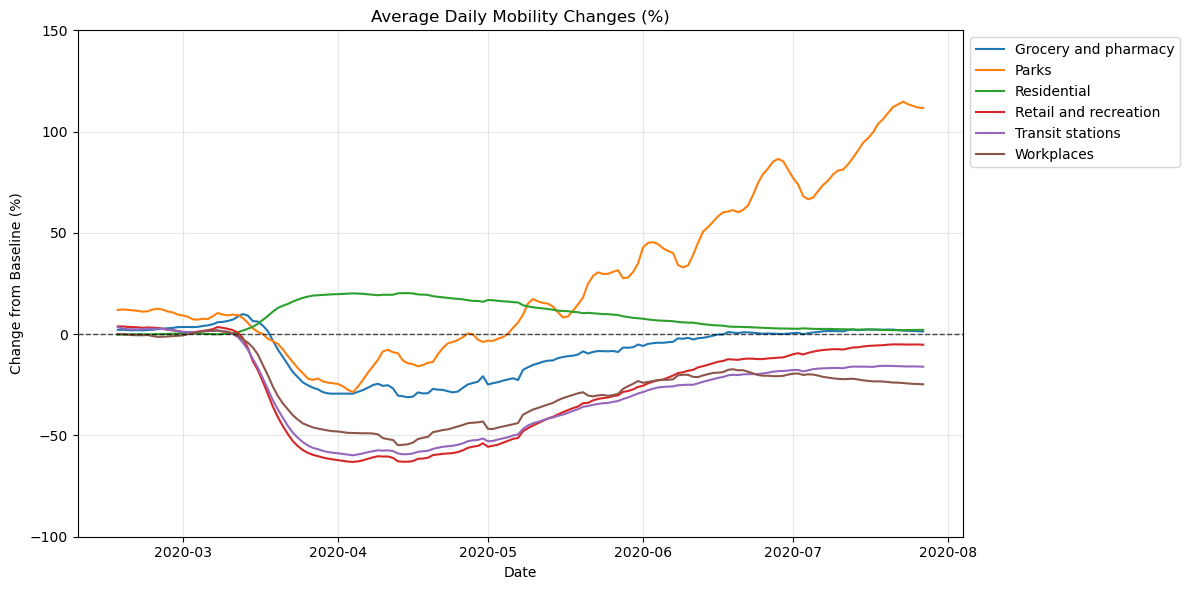

In [27]:

# Calculate daily averages across all countries/regions
daily_avg = (
    df.groupby("Date")[mobility_cols]
      .mean()
      .reset_index()
)

# --- Plot ---
plt.figure(figsize=(12, 6))

for col in mobility_cols:
    plt.plot(daily_avg["Date"], daily_avg[col], label=col)

plt.title("Average Daily Mobility Changes (%)")
plt.xlabel("Date")
plt.ylabel("Change from Baseline (%)")
plt.ylim(-100, 150)
plt.axhline(0, color="black", lw=1, linestyle="--", alpha=0.7)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [28]:
#merged cols - look for NaNs and check dtypes
check = df.loc[:, ~df.columns.isin(running_cols)].dtypes.to_frame("dtype")
check["NaN_count"] = df.loc[:, ~df.columns.isin(running_cols)].isna().sum()
check

,dtype,NaN_count
Grocery and pharmacy,float64,3386
Parks,float64,3438
Residential,float64,3438
Retail and recreation,float64,3385
Transit stations,float64,3278
Workplaces,float64,3278


In [29]:
running_cols = list(df.columns) #proceed to next merge

In [30]:
#our world in data: policy
#https://docs.owid.io/projects/etl/api/covid/#download-data


wd = pd.read_pickle(r'pickles/gov_policy.pkl')
wd["date"] = pd.to_datetime(wd["date"],format="%Y-%m-%d",errors="coerce")

cols = ['country', 'date', 'c1m_school_closing', 'c2m_workplace_closing',
       'c3m_cancel_public_events', 'c4m_restrictions_on_gatherings',
       'c5m_close_public_transport', 'c6m_stay_at_home_requirements',
       'c7m_restrictions_on_internal_movement',
       'c8ev_international_travel_controls', 'e1_income_support',
       'e2_debt_contract_relief','h1_public_information_campaigns',
       'h2_testing_policy', 'h3_contact_tracing',
       'h6m_facial_coverings']

wd = wd[cols]
only_in_wd = wd_countries - df_countries

df_countries    = set(df["Country/Region"].unique())
wd_countries    = set(wd["country"].unique())



# Countries only in df
only_in_df = df_countries - wd_countries

print("Only in df:", sorted(only_in_df))


df = df.merge(
    wd,
    left_on=['Country/Region', 'Date'],
    right_on=['country', 'date'],
    how='left'

).drop(columns={'country', 'date'})






Only in df: ['Armenia', 'Montenegro', 'North Macedonia']


In [31]:
df[df.columns.difference(running_cols)].describe().round(1)

,c1m_school_closing,c2m_workplace_closing,c3m_cancel_public_events,c4m_restrictions_on_gatherings,c5m_close_public_transport,c6m_stay_at_home_requirements,c7m_restrictions_on_internal_movement,c8ev_international_travel_controls,e1_income_support,e2_debt_contract_relief,h1_public_information_campaigns,h2_testing_policy,h3_contact_tracing,h6m_facial_coverings
count,9588.0,9588.0,9588.0,9588.0,9588.0,9588.0,9588.0,9588.0,9588.0,9588.0,9588.0,9588.0,9588.0,9588.0
mean,1.7,1.3,1.3,2.2,0.6,0.9,0.7,2.4,1.0,0.9,1.7,1.4,1.2,0.9
std,1.3,1.1,0.9,1.7,0.7,0.9,0.9,1.5,0.9,0.8,0.7,0.9,0.8,1.2
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0
50%,2.0,2.0,2.0,3.0,0.0,1.0,0.0,3.0,1.0,1.0,2.0,1.0,1.0,0.0
75%,3.0,2.0,2.0,4.0,1.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0
max,3.0,3.0,2.0,4.0,2.0,3.0,2.0,4.0,2.0,2.0,2.0,3.0,2.0,4.0


In [32]:
running_cols = list(df.columns) #proceed to next merge

In [33]:
#worldbank: total population

wb = pd.read_pickle(r'pickles/worldbank_population.pkl')
wb = wb[wb['TIME_PERIOD']==max_year]
wb = wb[['REF_AREA_LABEL','OBS_VALUE']]

#normalizing country names from worldbank datasets for applicable countries
wb['REF_AREA_LABEL'] = wb['REF_AREA_LABEL'].replace({
    'Russian Federation': 'Russia',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Slovak Republic': 'Slovakia',
    'Turkiye': 'Turkey'
})

df_countries    = set(df["Country/Region"].unique())
wb_countries    = set(wb["REF_AREA_LABEL"].unique())

# Countries only in df
only_in_df = df_countries - wb_countries

print("Countries with missing POPULATION data:", sorted(only_in_df))

df=df.merge(wb, right_on='REF_AREA_LABEL',left_on='Country/Region', how='left').drop(columns=['REF_AREA_LABEL']).rename(columns={'OBS_VALUE':'Population'})


Countries with missing POPULATION data: []


In [34]:
df[df.columns.difference(running_cols)].describe().round(1)

,Population
count,10152.0
mean,17154798.3
std,27565734.1
min,34770.0
25%,2102419.0
50%,6638646.0
75%,11538604.0
max,145245148.0


In [35]:
#merged cols - look for NaNs and check dtypes
check = df.loc[:, ~df.columns.isin(running_cols)].dtypes.to_frame("dtype")
check["NaN_count"] = df.loc[:, ~df.columns.isin(running_cols)].isna().sum()
check

,dtype,NaN_count
Population,int64,0


In [36]:
df[df.columns.difference(running_cols)].describe().round(1)

,Population
count,10152.0
mean,17154798.3
std,27565734.1
min,34770.0
25%,2102419.0
50%,6638646.0
75%,11538604.0
max,145245148.0


In [37]:
#population bins

bins = [0, 1e6, 5e6, 10e6, 50e6, 100e6, 200e6]
labels = ["<1M", "1–5M", "5–10M", "10–50M", "50–100M", ">100M"]
df["Pop_Group"] = pd.cut(df["Population"], bins=bins, labels=labels, include_lowest=True)
df["Pop_Group_encoded"] = df["Region"].astype("category").cat.codes #so we cat drop the cat column later safely

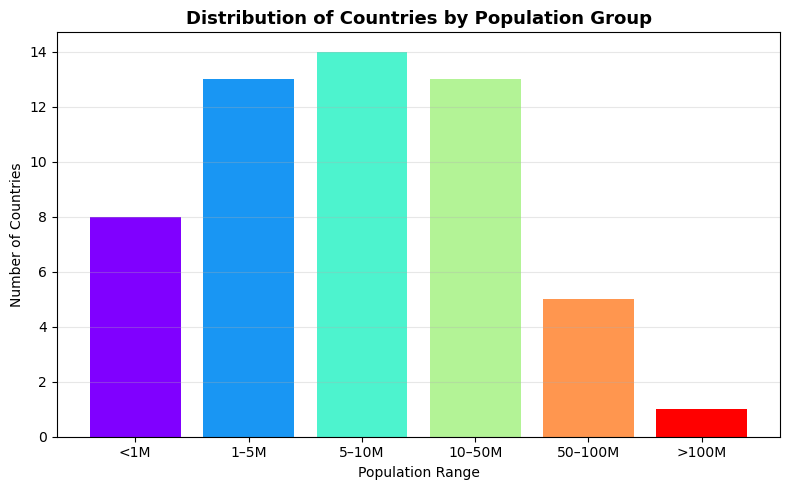

In [38]:
#Population Grouping for Visualization

pop_data = (
    df.groupby("Country/Region", as_index=False)["Population"]
      .max()
)

pop_data["Population Group"] = pd.cut(pop_data["Population"], bins=bins, labels=labels, include_lowest=True)

# --- Count how many countries fall into each bin ---
group_counts = pop_data["Population Group"].value_counts().sort_index()

# --- Plot ---
plt.figure(figsize=(8, 5))
colors = plt.cm.rainbow(np.linspace(0, 1, len(group_counts)))

plt.bar(group_counts.index, group_counts.values, color=colors, edgecolor="none")
plt.title("Distribution of Countries by Population Group", fontsize=13, weight="bold")
plt.xlabel("Population Range")
plt.ylabel("Number of Countries")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [39]:
running_cols = list(df.columns) #proceed to next merge

In [40]:
#worldbank: population density
density=pd.read_pickle(r'pickles\pop_density.pkl')

#normalizing country names from worldbank datasets for applicable countries
density['Country Name'] = density['Country Name'].replace({
    'Russian Federation': 'Russia',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Slovak Republic': 'Slovakia',
    'Turkiye': 'Turkey'
})

df_countries    = set(df["Country/Region"].unique())
den_countries    = set(density["Country Name"].unique())

# Countries only in df
only_in_df = df_countries - den_countries

print("Countries with missing DENSITY data:", sorted(only_in_df))

density = density[['Country Name', str(max_year)]]
df=df.merge(density, right_on='Country Name',left_on='Country/Region', how='left').drop(columns=['Country Name']).rename(columns={str(max_year):'Pop.Density'})



Countries with missing DENSITY data: []


In [41]:
#merged cols - look for NaNs and check dtypes
check = df.loc[:, ~df.columns.isin(running_cols)].dtypes.to_frame("dtype")
check["NaN_count"] = df.loc[:, ~df.columns.isin(running_cols)].isna().sum()
check

,dtype,NaN_count
Pop.Density,float64,188


In [42]:
#only 1 country is entirely missing from datasource, easy to see from the NaN country (188 observations per country
df[df["Pop.Density"].isna()]['Country/Region'].unique()

array(['Kosovo'], dtype=object)

In [43]:
df.loc[df['Country/Region'] == 'Kosovo', 'Pop.Density'] = 162.9  #source: https://countrymeters.info/en/Kosovo

In [44]:
#check it worked 
check = df.loc[:, ~df.columns.isin(running_cols)].dtypes.to_frame("dtype")
check["NaN_count"] = df.loc[:, ~df.columns.isin(running_cols)].isna().sum()
check

,dtype,NaN_count
Pop.Density,float64,0


In [45]:
df[df.columns.difference(running_cols)].describe().round(1)

,Pop.Density
count,10152.0
mean,501.3
std,2520.5
min,3.6
25%,64.4
50%,104.0
75%,162.9
max,18771.6


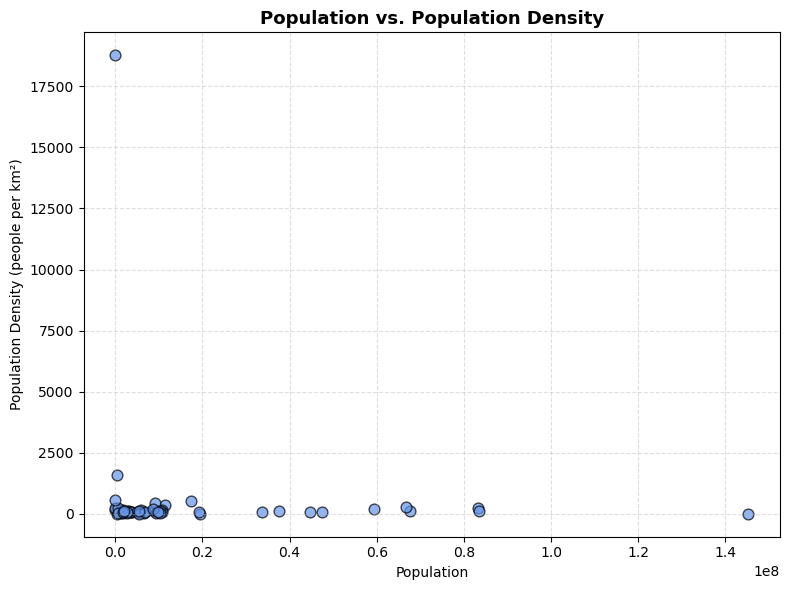

In [46]:
#Population to Population density

pop_density = (
    df.groupby("Country/Region", as_index=False)
      .agg({"Population": "max", "Pop.Density": "max"})
      .dropna(subset=["Population", "Pop.Density"])
)

# --- plot ---
plt.figure(figsize=(8, 6))
plt.scatter(
    pop_density["Population"],
    pop_density["Pop.Density"],
    alpha=0.7,
    color="cornflowerblue",
    edgecolor="k",
    s=60
)

plt.title("Population vs. Population Density", fontsize=13, weight="bold")
plt.xlabel("Population")
plt.ylabel("Population Density (people per km²)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [47]:
df['Pop.Density'].describe()

count    10152.000000
mean       501.259814
std       2520.462287
min          3.634464
25%         64.440410
50%        103.990006
75%        162.900000
max      18771.583620
Name: Pop.Density, dtype: float64

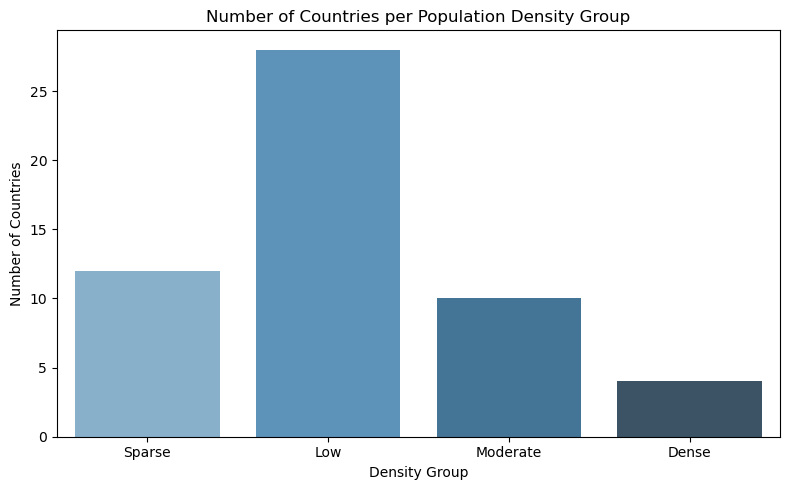

     Density_Group  Density_Group_encoded
940         Sparse                      0
0              Low                      1
188       Moderate                      2
5828         Dense                      3


In [48]:
#Population Density into bins


bins = [-float('inf'), 50, 150, 500, float('inf')]
labels = ['Sparse', 'Low', 'Moderate', 'Dense']

# --- Step 2: Assign bins per unique country ---
country_density = (
    df[['Country/Region', 'Pop.Density']]
    .drop_duplicates('Country/Region')
    .reset_index(drop=True)
)
country_density['Density_Group'] = pd.cut(country_density['Pop.Density'], bins=bins, labels=labels)

# --- Step 3: Encode Density_Group (explicitly ordered) ---
ordered_cat = pd.CategoricalDtype(categories=labels, ordered=True)
country_density['Density_Group'] = country_density['Density_Group'].astype(ordered_cat)
country_density['Density_Group_encoded'] = country_density['Density_Group'].cat.codes

# --- Step 4: Merge encoded data back into main df ---
df = df.merge(
    country_density[['Country/Region', 'Density_Group', 'Density_Group_encoded']],
    on='Country/Region',
    how='left'
)

# --- Step 5: Count countries per group ---
density_counts = (
    country_density['Density_Group']
    .value_counts()
    .reindex(labels)  # maintain logical order
    .reset_index()
)
density_counts.columns = ['Density_Group', 'Country_Count']

# --- Step 6: Plot (no deprecation warnings) ---
plt.figure(figsize=(8, 5))
sns.barplot(
    data=density_counts,
    x='Density_Group',
    y='Country_Count',
    hue='Density_Group',
    palette='Blues_d',
    legend=False
)
plt.title('Number of Countries per Population Density Group')
plt.xlabel('Density Group')
plt.ylabel('Number of Countries')
plt.tight_layout()
plt.show()

# --- Step 7: Verify encoding table ---
print(df[['Density_Group', 'Density_Group_encoded']].drop_duplicates().sort_values('Density_Group_encoded'))

In [49]:
running_cols = list(df.columns) #proceed to next merge, outliers will be handled in next section

In [50]:
#worldbank: aging population (ged 65 and above)

age = pd.read_pickle(r'pickles/worldbank_old_ratio.pkl')
age = age[age['TIME_PERIOD']==max_year]
age = age[['REF_AREA_LABEL', 'TIME_PERIOD','OBS_VALUE']]

df_countries    = set(df["Country/Region"].unique())
age_countries    = set(age["REF_AREA_LABEL"].unique())

#normalizing country names from worldbank datasets for applicable countries
age['REF_AREA_LABEL'] = age['REF_AREA_LABEL'].replace({
    'Russian Federation': 'Russia',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Slovak Republic': 'Slovakia',
    'Turkiye': 'Turkey'
})

df_countries    = set(df["Country/Region"].unique())
age_countries    = set(age["REF_AREA_LABEL"].unique())


# Countries only in df
only_in_df = df_countries - age_countries

print("Countries with missing AGING data:", sorted(only_in_df))

age = age[['REF_AREA_LABEL', 'OBS_VALUE']]
df=df.merge(age, right_on='REF_AREA_LABEL',left_on='Country/Region', how='left').drop(columns=['REF_AREA_LABEL']).rename(columns={'OBS_VALUE':'% aging.pop'}).round(2)

Countries with missing AGING data: []


In [51]:
#worldbank: young population (age 15 and under)

age = pd.read_pickle(r'pickles/worldbank_young_ratio.pkl')
age = age[age['TIME_PERIOD']==max_year]
age = age[['REF_AREA_LABEL', 'TIME_PERIOD','OBS_VALUE']]


df_countries    = set(df["Country/Region"].unique())
age_countries    = set(age["REF_AREA_LABEL"].unique())

# Countries only in df
only_in_df = df_countries - age_countries

print("Only in df:", sorted(only_in_df))

age['REF_AREA_LABEL'] = age['REF_AREA_LABEL'].replace({
    'Russian Federation': 'Russia',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Slovak Republic': 'Slovakia',
    'Turkiye': 'Turkey'
})

df_countries    = set(df["Country/Region"].unique())
age_countries    = set(age["REF_AREA_LABEL"].unique())


# Countries only in df
only_in_df = df_countries - age_countries

print("Countries with missing YOUNG data::", sorted(only_in_df))

age = age[['REF_AREA_LABEL', 'OBS_VALUE']]
df=df.merge(age, right_on='REF_AREA_LABEL',left_on='Country/Region', how='left').drop(columns=['REF_AREA_LABEL']).rename(columns={'OBS_VALUE':'% young.pop'}).round(2)

Only in df: ['Kyrgyzstan', 'Russia', 'Slovakia', 'Turkey']
Countries with missing YOUNG data:: []


In [52]:
check = df.loc[:, ~df.columns.isin(running_cols)].dtypes.to_frame("dtype")
check["NaN_count"] = df.loc[:, ~df.columns.isin(running_cols)].isna().sum()
check

,dtype,NaN_count
% aging.pop,float64,0
% young.pop,float64,0


In [53]:
#OLD V YOUNG
old_v_young = df.groupby('Region')[['Dead/100 Cases','% aging.pop', '% young.pop']].mean().round(2).sort_values(by='% aging.pop', ascending=False)
old_v_young

,Dead/100 Cases,% aging.pop,% young.pop
Region,,,
Southern Europe,4.16,33.91,21.20
Northern Europe,2.45,30.54,26.05
Western Europe,5.25,28.51,24.82
Eastern Europe,2.78,27.51,24.53
Balkans,2.17,26.12,25.49
Caucasus,0.97,17.13,32.07
Other,1.28,16.62,40.07
Central Asia,0.56,8.50,51.38


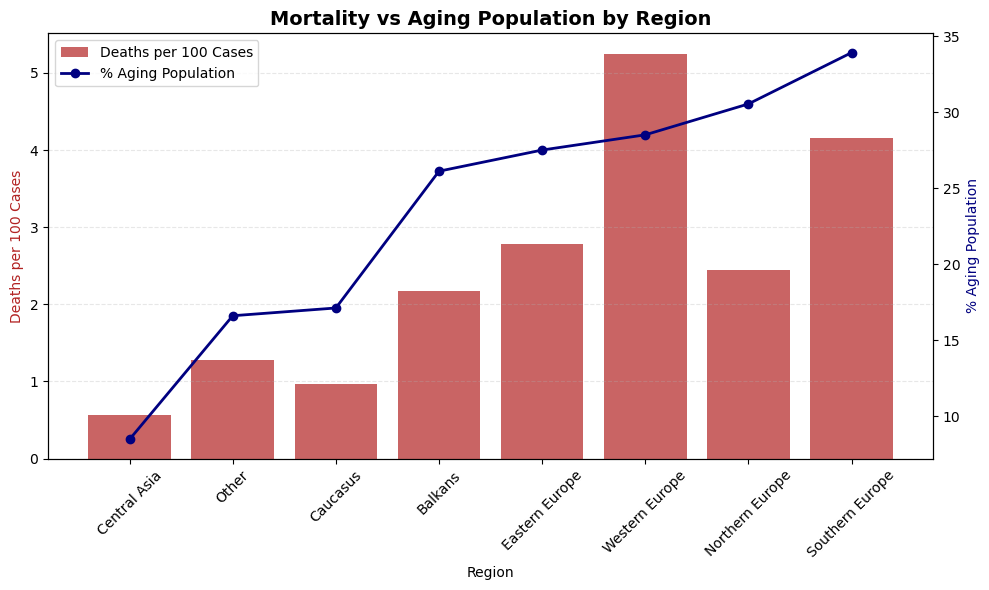

In [54]:

# --- Sort by % aging population ---
plot_df = old_v_young.sort_values("% aging.pop")

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Bars: Deaths per 100 cases
ax1.bar(plot_df.index, plot_df["Dead/100 Cases"], color="firebrick", alpha=0.7, label="Deaths per 100 Cases")

# Line: Aging population
ax2.plot(plot_df.index, plot_df["% aging.pop"], color="navy", marker="o", linewidth=2, label="% Aging Population")

# --- Labels and title ---
ax1.set_title("Mortality vs Aging Population by Region", fontsize=14, weight="bold")
ax1.set_xlabel("Region")
ax1.set_ylabel("Deaths per 100 Cases", color="firebrick")
ax2.set_ylabel("% Aging Population", color="navy")

ax1.tick_params(axis="x", rotation=45)
ax1.grid(axis="y", linestyle="--", alpha=0.3)

# --- Combine legends from both axes ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()



In [55]:
df[['% aging.pop','% young.pop']].describe() 

,% aging.pop,% young.pop
count,10152.000000,10152.000000
mean,26.642222,27.362222
std,9.918198,8.372332
min,5.410000,18.510000
25%,21.810000,22.590000
50%,28.135000,25.240000
75%,31.860000,28.400000
max,71.860000,60.440000


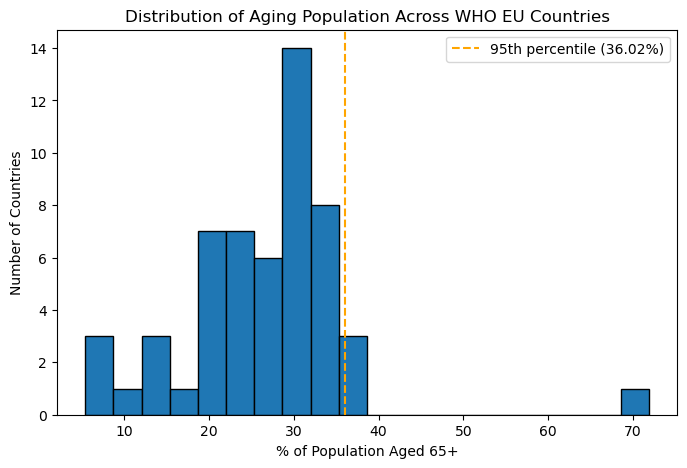

Monaco is a top 5% aging country with 71.86% of its population aged 65+.
Italy is a top 5% aging country with 36.65% of its population aged 65+.
Finland is a top 5% aging country with 36.36% of its population aged 65+.


In [56]:

# Remove duplicates so each country appears only once
df_unique = df.drop_duplicates(subset='Country/Region')

# Calculate 95th percentile
cutoff = np.percentile(df_unique['% aging.pop'], 95)

# Get top 5% countries
outliers = df_unique[df_unique['% aging.pop'] > cutoff].sort_values('% aging.pop', ascending=False)

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(df_unique['% aging.pop'], bins=20, edgecolor='black')
plt.axvline(cutoff, color='orange', linestyle='--', label=f'95th percentile ({cutoff:.2f}%)')
plt.xlabel('% of Population Aged 65+')
plt.ylabel('Number of Countries')
plt.title('Distribution of Aging Population Across WHO EU Countries')
plt.legend()
plt.show()

# Print each country once
for _, row in outliers.iterrows():
    print(f"{row['Country/Region']} is a top 5% aging country with {row['% aging.pop']:.2f}% of its population aged 65+.")


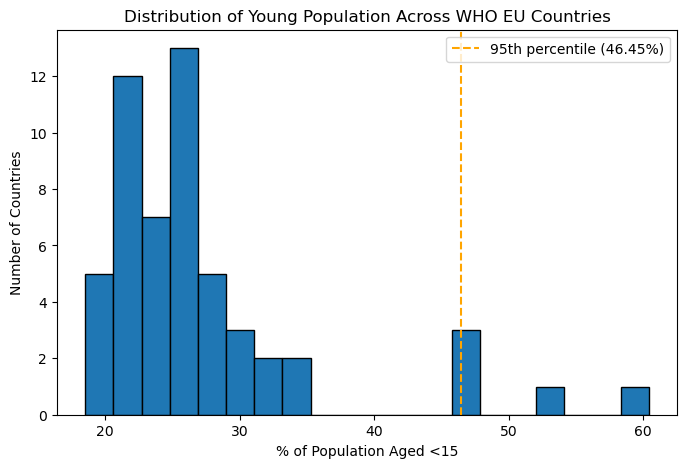

Tajikistan is a top 5% young country with 60.44% of its population aged 15 and under.
Kyrgyzstan is a top 5% young country with 53.04% of its population aged 15 and under.
Israel is a top 5% young country with 46.79% of its population aged 15 and under.


In [57]:
# Remove duplicates so each country appears only once
df_unique = df.drop_duplicates(subset='Country/Region')

# Calculate 95th percentile
cutoff = np.percentile(df_unique['% young.pop'], 95)

# Get top 5% countries
outliers = df_unique[df_unique['% young.pop'] > cutoff].sort_values('% young.pop', ascending=False)

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(df_unique['% young.pop'], bins=20, edgecolor='black')
plt.axvline(cutoff, color='orange', linestyle='--', label=f'95th percentile ({cutoff:.2f}%)')
plt.xlabel('% of Population Aged <15')
plt.ylabel('Number of Countries')
plt.title('Distribution of Young Population Across WHO EU Countries')
plt.legend()
plt.show()

# Print each country once
for _, row in outliers.iterrows():
    print(f"{row['Country/Region']} is a top 5% young country with {row['% young.pop']:.2f}% of its population aged 15 and under.")

In [58]:
#capped Monaco only - see documentation

df.loc[df['Country/Region'] == 'Monaco', '% aging.pop'] = 36.65



In [59]:
running_cols = list(df.columns) #proceed to next merge, outliers will be handled in next section

In [60]:
#worldbank: GDP
gdp=pd.read_pickle(r'pickles\worldbank_gdp.pkl')

df_countries    = set(df["Country/Region"].unique())
gdp_countries    = set(gdp["Country Name"].unique())

# Countries only in df
only_in_df = df_countries - gdp_countries
only_in_wd = gdp_countries - df_countries


gdp['Country Name'] = gdp['Country Name'].replace({
    'Russian Federation': 'Russia',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Slovak Republic': 'Slovakia',
    'Turkiye': 'Turkey'
})

df_countries    = set(df["Country/Region"].unique())
gdp_countries    = set(gdp["Country Name"].unique())

# Countries only in df
only_in_df = df_countries - gdp_countries

print("Countries with missing GDP data:", sorted(only_in_df))

gdp = gdp[['Country Name', str(max_year)]]
df=df.merge(gdp, right_on='Country Name',left_on='Country/Region', how='left').drop(columns=['Country Name']).rename(columns={str(max_year):'GDP'})




Countries with missing GDP data: []


In [61]:
#wordbank: GDP healthcare ratio (% of GDP country spends on healthcare)

gdp_per = pd.read_pickle(r'pickles\worldbank_healthcare_percent.pkl')

gdp_per = gdp_per[gdp_per['TIME_PERIOD']==max_year].reset_index(drop=True)
gdp_per = gdp_per[['OBS_VALUE', 'REF_AREA_LABEL']]

gdp_per['REF_AREA_LABEL'] = gdp_per['REF_AREA_LABEL'].replace({
    'Russian Federation': 'Russia',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Slovak Republic': 'Slovakia',
    'Turkiye': 'Turkey'
})

df_countries    = set(df["Country/Region"].unique())
per_countries    = set(gdp_per["REF_AREA_LABEL"].unique())

only_in_df = df_countries - per_countries

print("Countries with missing GDP HEALTHCARE data:", sorted(only_in_df))

df=df.merge(gdp_per, right_on='REF_AREA_LABEL',left_on='Country/Region', how='left').drop(columns=['REF_AREA_LABEL']).rename(columns={'OBS_VALUE':'% healthcare'}).round(2)

#countries %healthcare spend according to various online sources
df.loc[df['Country/Region'] == 'Liechtenstein', '% healthcare'] = 0.39
df.loc[df['Country/Region'] == 'Kosovo', '% healthcare'] = 4.50

#converts to billions
df["GDP_billions"] = df["GDP"]/ 1e9

#adding GDP per capita for normalization
df["GDP_per_capita"] = df["GDP"] / df["Population"]







Countries with missing GDP HEALTHCARE data: ['Kosovo', 'Liechtenstein']


In [62]:
check = df.loc[:, ~df.columns.isin(running_cols)].dtypes.to_frame("dtype")
check["NaN_count"] = df.loc[:, ~df.columns.isin(running_cols)].isna().sum()
check

,dtype,NaN_count
GDP,float64,0
% healthcare,float64,0
GDP_billions,float64,0
GDP_per_capita,float64,0


In [63]:
#GDP v. GDP Spend %
gdp_v_spend = df.groupby('Region')[['Dead/100 Cases','GDP_billions', 'GDP_per_capita','% healthcare']].mean().round(2).sort_values(by='GDP_per_capita', ascending=False)
gdp_v_spend

,Dead/100 Cases,GDP_billions,GDP_per_capita,% healthcare
Region,,,,
Western Europe,5.25,1244.61,72926.90,6.99
Southern Europe,4.16,408.24,45522.07,6.47
Northern Europe,2.45,210.41,43984.44,7.51
Other,1.28,565.50,26617.69,4.44
Eastern Europe,2.78,292.62,13606.58,5.38
Balkans,2.17,24.88,7570.20,5.37
Caucasus,0.97,23.78,4266.48,2.78
Central Asia,0.56,63.46,3204.85,2.48


In [64]:
running_cols = list(df.columns) #proceed to next merge, outliers will be handled in next section

In [65]:
#worldbank: smokers

wb = pd.read_pickle(r'pickles/worldbank_smokers.pkl')
wb = wb[wb['TIME_PERIOD']==max_year]
wb = wb[['REF_AREA_LABEL','OBS_VALUE']]

df_countries    = set(df["Country/Region"].unique())
wb_countries    = set(wb["REF_AREA_LABEL"].unique())

# Countries only in df
wb['REF_AREA_LABEL'] = wb['REF_AREA_LABEL'].replace({
    'Russian Federation': 'Russia',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Slovak Republic': 'Slovakia',
    'Turkiye': 'Turkey'
})

df_countries    = set(df["Country/Region"].unique())
wb_countries    = set(wb["REF_AREA_LABEL"].unique())

only_in_df = df_countries - wb_countries
print("Countries with missing SMOKERS data:", sorted(only_in_df))

df=df.merge(wb, right_on='REF_AREA_LABEL',left_on='Country/Region', how='left').drop(columns=['REF_AREA_LABEL']).rename(columns={'OBS_VALUE':'% smoking'}).round(2)

#countries % smoking habits according to various online sources
df.loc[df['Country/Region'] == 'Kosovo', '% smoking'] = 25.7    #source: https://www.seejph.com/index.php/seejph/article/view/376
df.loc[df['Country/Region'] == 'Liechtenstein', '% smoking'] = 27.0  #source: https://www.llv.li/de/aktuelles/zahl-tag/3-von-4-rauchen-nicht-27378
df.loc[df['Country/Region'] == 'Monaco', '% smoking'] = 26.0  #source: https://tobaccoatlas.org/factsheets/monaco/
df.loc[df['Country/Region'] == 'North Macedonia', '% smoking'] = 48.4  #source: https://www.economicsforhealth.org/research/tobacco-consumption-in-north-macedonia-fact-sheet/
df.loc[df['Country/Region'] == 'San Marino', '% smoking'] = 20.0  #source: https://tobaccoatlas.org/factsheets/san-marino/
df.loc[df['Country/Region'] == 'Tajikistan', '% smoking'] = 9.0  #source: https://tobaccoatlas.org/factsheets/tajikistan/



Countries with missing SMOKERS data: ['Kosovo', 'Liechtenstein', 'Monaco', 'North Macedonia', 'San Marino', 'Tajikistan']


In [66]:
check = df.loc[:, ~df.columns.isin(running_cols)].dtypes.to_frame("dtype")
check["NaN_count"] = df.loc[:, ~df.columns.isin(running_cols)].isna().sum()
check

,dtype,NaN_count
% smoking,float64,0


In [67]:
smokers = df.groupby('Region')[['Dead/100 Cases','% smoking']].mean().round(2).sort_values(by='% smoking', ascending=False)
smokers

,Dead/100 Cases,% smoking
Region,,
Balkans,2.17,34.71
Eastern Europe,2.78,29.70
Southern Europe,4.16,28.30
Caucasus,0.97,25.97
Other,1.28,25.95
Western Europe,5.25,24.52
Northern Europe,2.45,23.49
Central Asia,0.56,19.25


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10152 entries, 0 to 10151
Data columns (total 71 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Country/Region                         10152 non-null  object        
 1   Lat                                    10152 non-null  float64       
 2   Long                                   10152 non-null  float64       
 3   Date                                   10152 non-null  datetime64[ns]
 4   Confirmed                              10152 non-null  int64         
 5   Deaths                                 10152 non-null  int64         
 6   Recovered                              10152 non-null  int64         
 7   Active                                 10152 non-null  int64         
 8   Continent                              10152 non-null  object        
 9   Region                                 10152 non-null  object

In [69]:
#sorted by NaN
summary = pd.DataFrame({
    "dtype": df.dtypes,
    "min": df.min(numeric_only=True),
    "max": df.max(numeric_only=True),
    "nunique": df.nunique(),
    "na_%": (df.isna().sum() / len(df) * 100).round(0)
})

# Reset index for readability
summary = summary.reset_index().rename(columns={"index": "column"}).sort_values("na_%", ascending=False)



summary.head(25)

,column,dtype,min,max,nunique,na_%
66,new_tests_per_thousand,float64,0.0,25.3,380,54.0
64,new_tests,float64,1.0,355443.0,3673,54.0
70,total_tests_per_thousand,float64,0.0,703.6,3617,52.0
69,total_tests,float64,1.0,27327570.0,4816,52.0
65,new_tests_7day_smoothed,float64,0.0,312164.0,4122,49.0
67,new_tests_per_thousand_7day_smoothed,float64,0.0,18.6,344,49.0
34,Residential,float64,-4.29,34.33,302,34.0
25,Parks,float64,-83.71,349.43,1761,34.0
19,Grocery and pharmacy,float64,-65.29,29.43,688,33.0
35,Retail and recreation,float64,-91.71,21.29,843,33.0


In [70]:
df.to_pickle(r'pickles/df1.1.pkl')